In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import pandas as pd
import yfinance

# Import the backtrader platform
import backtrader as bt

data = yfinance.download("MDB", start='2020-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,130.179993,134.669998,126.080002,134.330002,134.330002,1166900
2020-01-03,132.429993,136.220001,131.759995,135.289993,135.289993,598300
2020-01-06,132.880005,140.889999,132.705002,140.500000,140.500000,1254600
2020-01-07,140.500000,142.610001,138.250000,138.860001,138.860001,672000
2020-01-08,138.899994,141.639999,136.229996,140.270004,140.270004,978800
...,...,...,...,...,...,...
2023-04-24,234.000000,235.520004,222.630005,223.960007,223.960007,1310900
2023-04-25,220.059998,221.160004,212.522995,212.910004,212.910004,1467500
2023-04-26,226.199997,243.399994,226.199997,238.220001,238.220001,3416800


In [6]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.sma = bt.ind.SMA(period=200)
        self.boll = bt.ind.BollingerBands(period=20, devfactor=2.5)
        self.rsi = bt.ind.RSI(period=2, safediv=True)
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            if self.dataclose > self.sma and \
            self.dataclose < self.boll.lines.bot:

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(exectype=bt.Order.Limit, price=0.97*self.dataclose[0])

        else:

            # Already in the market ... we might sell
            if self.rsi > 50 or len(self) >= (self.bar_executed + 10):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)


    # Create a Data Feed
    feed_data = bt.feeds.PandasData(dataname=data)

    # Add the Data Feed to Cerebro
    cerebro.adddata(feed_data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2020-10-15, Close, 269.87
2020-10-16, Close, 267.30
2020-10-19, Close, 265.24
2020-10-20, Close, 256.68
2020-10-21, Close, 248.84
2020-10-22, Close, 245.75
2020-10-23, Close, 248.00
2020-10-26, Close, 240.10
2020-10-27, Close, 244.01
2020-10-28, Close, 240.04
2020-10-29, Close, 235.69
2020-10-30, Close, 228.47
2020-11-02, Close, 224.18
2020-11-03, Close, 226.97
2020-11-04, Close, 244.67
2020-11-05, Close, 253.15
2020-11-06, Close, 252.40
2020-11-09, Close, 239.89
2020-11-10, Close, 230.06
2020-11-11, Close, 245.09
2020-11-12, Close, 251.02
2020-11-13, Close, 246.86
2020-11-16, Close, 242.94
2020-11-17, Close, 248.34
2020-11-18, Close, 247.34
2020-11-19, Close, 255.11
2020-11-20, Close, 264.28
2020-11-23, Close, 265.35
2020-11-24, Close, 264.60
2020-11-25, Close, 265.40
2020-11-27, Close, 270.02
2020-11-30, Close, 287.31
2020-12-01, Close, 275.30
2020-12-02, Close, 267.91
2020-12-03, Close, 272.01
2020-12-04, Close, 277.63
2020-12-07, Close, 280.46
202

In [8]:
#%matplotlib inline

<IPython.core.display.Javascript object>


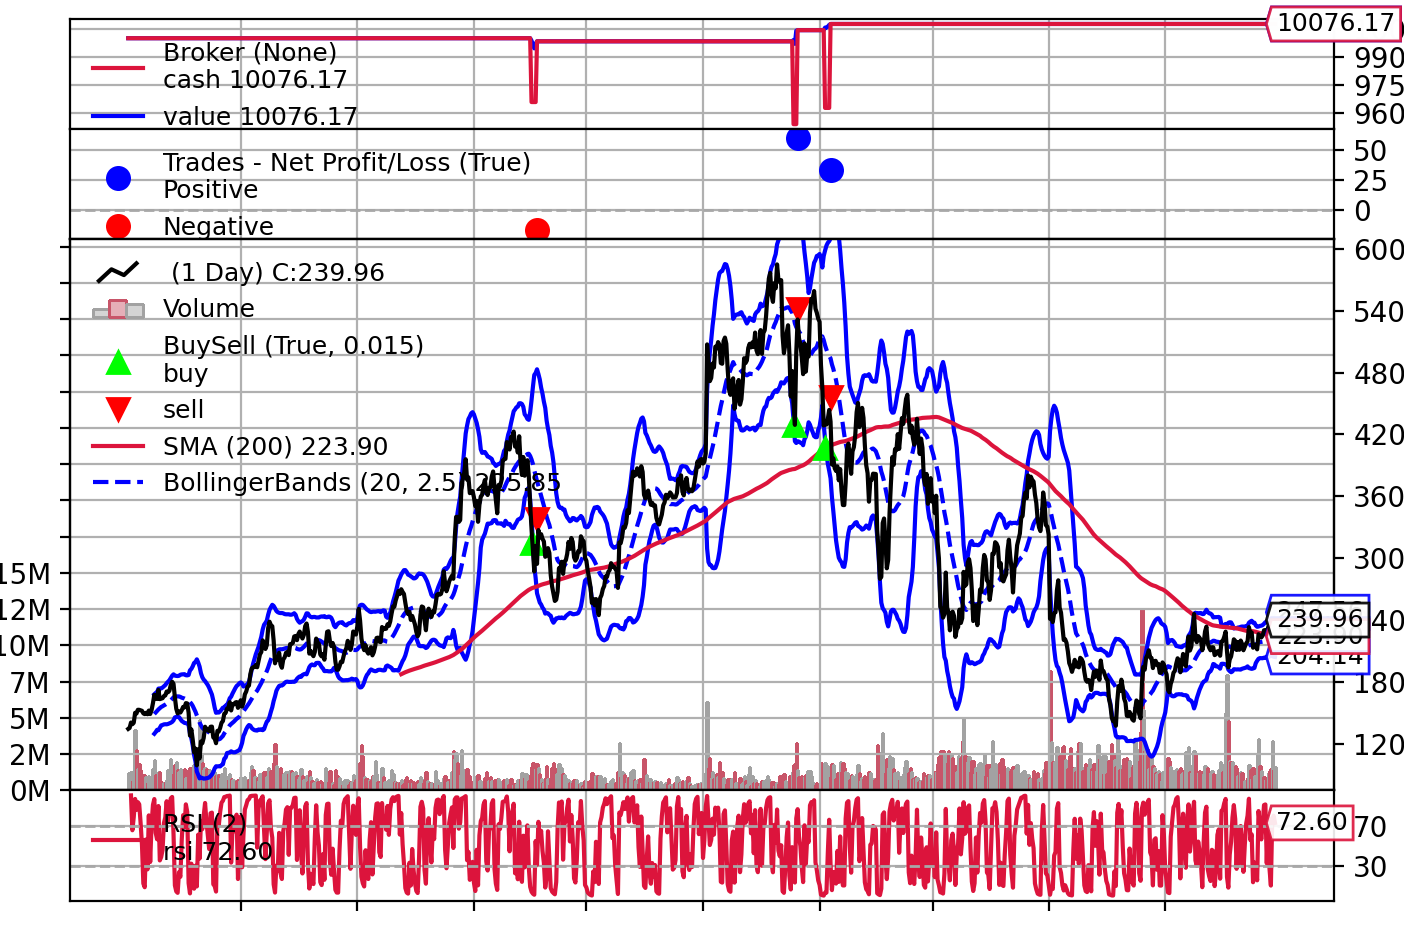

[[<Figure size 640x480 with 5 Axes>]]

In [9]:
cerebro.plot()